--- 

---
# Book-Crossing Dataset
---

---

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cross_validation import train_test_split

### 1. Reading files

In [2]:
books = pd.read_csv('book-crossing/BX-Books.csv', skiprows=1, sep=';',
                    names=['book_id', 'title', 'author', 'year', 'publisher', 'url1', 'url2', 'url3'])
books.drop(['url1', 'url2', 'url3'], axis=1, inplace=True)
print books.shape
books.head()

(271379, 5)


C:\Python27\lib\site-packages\pandas\io\parsers.py:1170: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


,book_id,title,author,year,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [3]:
users = pd.read_csv('book-crossing/BX-Users.csv', skiprows=1, sep=';', names=['user_id', 'location', 'age'])
print users.shape
users.head()

(278858, 3)


,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",NaN


In [4]:
ratings = pd.read_csv('book-crossing/BX-Book-Ratings.csv', skiprows=1, sep=';', names=['user_id', 'book_id', 'rating'])
ratings.rating = ratings.rating.astype(int)
print ratings.dtypes
print ratings.shape
ratings.head()

user_id     int64
book_id    object
rating      int32
dtype: object
(1149780, 3)


,user_id,book_id,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [5]:
# We can calculate the fill rate of rating matrix
fill_rate = (1.0 * ratings.shape[0] / len(ratings.user_id.drop_duplicates()) / len(ratings.book_id.drop_duplicates())) * 100
fill_rate

0.003206771109452608

We can see, rating matrix is a very sparse matrix, only 0.003% of fields are filled. 

### 2. Tables merging and Data analysis

In [6]:
book_crossing = pd.merge(pd.merge(ratings, books), users)
print book_crossing.shape
book_crossing.head()

(1031175, 9)


,user_id,book_id,rating,title,author,year,publisher,location,age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"tyler, texas, usa",NaN
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"cincinnati, ohio, usa",23
2,2313,0812533550,9,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986,Tor Books,"cincinnati, ohio, usa",23
3,2313,0679745580,8,In Cold Blood (Vintage International),TRUMAN CAPOTE,1994,Vintage,"cincinnati, ohio, usa",23
4,2313,0060173289,9,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells,1996,HarperCollins,"cincinnati, ohio, usa",23


<u><h1>STOP</h1></u>
---

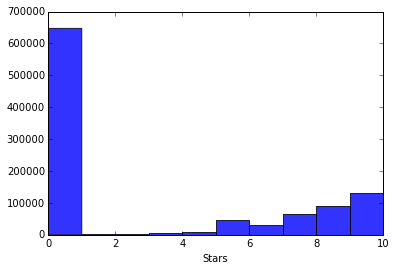

In [7]:
# Display the most common ratings
plt.hist(book_crossing.rating, bins=10, color='blue', alpha=0.8)
plt.xlabel("Stars")
plt.show()

What we see:

* there are too many not rated books (with 0 rating), i.e. zero rating tell us that a user read book (or only look at it), but did not rate it. This information does not contain any good for us

* people like a big part of books and evaluate them from 5 to 10 stars

* there a large percent of books rated with 10

ratings shape before removing: (1149780, 3)
ratings shape after removing: (433671, 3)
persent of zero ratings: 62.2822626937
0.00299711203416
(383852, 9)


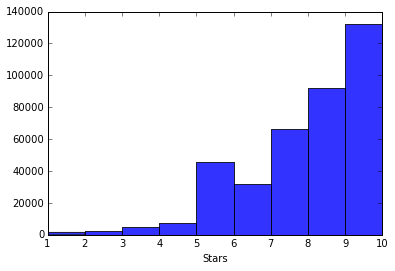

In [8]:
# Above analysis allows removing not rated books
x = ratings.shape
print "ratings shape before removing:", x
ratings = ratings[ratings.rating != 0]
print "ratings shape after removing:", ratings.shape

print "persent of zero ratings:", (1 - 1.0 * ratings.shape[0] / x[0]) * 100

fill_rate = (1.0 * ratings.shape[0] / len(ratings.user_id.drop_duplicates()) / len(ratings.book_id.drop_duplicates())) * 100
print fill_rate

book_crossing = pd.merge(pd.merge(ratings, books), users)
print book_crossing.shape

# Display the most common ratings
plt.hist(book_crossing.rating, bins=9, color='blue', alpha=0.8)
plt.xlabel("Stars")
plt.show()

What we see:

* after removing of nearby 62% of book/user pair with zero rating the fill_rate parameter was almost not changed

* we can work with a smaller dataset

In [9]:
# Let's show top 20 authors by readers amount
top_authors = book_crossing.groupby('author')['rating'].count()
top_authors.sort(inplace=True, ascending=False)
top_authors[:20]

author
Stephen King                 4639
Nora Roberts                 2938
John Grisham                 2550
James Patterson              2387
J. K. Rowling                1746
Mary Higgins Clark           1677
Janet Evanovich              1490
Dean R. Koontz               1475
Anne Rice                    1245
Sue Grafton                  1235
Tom Clancy                   1223
Michael Crichton             1147
Nicholas Sparks              1131
JOHN GRISHAM                 1120
Dan Brown                    1104
Danielle Steel               1076
Anita Shreve                 1027
Barbara Kingsolver           1008
Patricia Daniels Cornwell     943
Alice Sebold                  928
Name: rating, dtype: int64

In [10]:
# Let's show top 20 authors by average rating
# We will consider here only those authors who has at least 50 readers
top_authors = book_crossing[book_crossing['author'].isin(top_authors[top_authors >= 50].index.values)].groupby('author')['rating'].mean()
top_authors.sort(inplace=True, ascending=False)
top_authors[:20]

author
Maud Hart Lovelace          9.288462
Art Spiegelman              9.240000
Bill Watterson              9.186186
Dr. Seuss                   9.178744
Shel Silverstein            9.158730
Antoine de Saint-Exupéry    9.029240
Bradley Trevor Greive       8.988095
Harper Lee                  8.985765
J. K. Rowling               8.970218
Clamp                       8.963303
J.R.R. TOLKIEN              8.897590
L.M. MONTGOMERY             8.889908
L.M. Montgomery             8.852632
E. B. White                 8.846154
WILLIAM GOLDMAN             8.818182
Nick Bantock                8.766871
MADELEINE L'ENGLE           8.762887
Betty Smith                 8.759259
Anne Frank                  8.752475
Lucy Maud Montgomery        8.745763
Name: rating, dtype: float64

user_id
11676     6943
98391     5691
189835    1899
153662    1845
23902     1180
235105    1020
76499     1012
171118     962
16795      959
248718     941
56399      838
197659     781
35859      777
185233     698
95359      606
114368     603
158295     567
101851     563
177458     524
204864     504
Name: book_id, dtype: int64


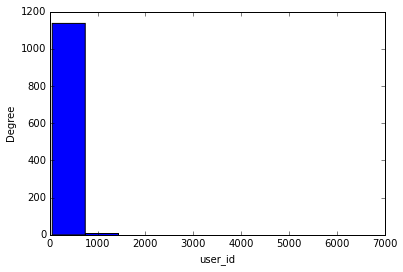

In [11]:
# Let's show top 20 users (i.e. who has rated the largest amount of books)
top_users = book_crossing.groupby('user_id')['book_id'].count()
top_users.sort(inplace=True, ascending=False)
print top_users[:20]

top_users[top_users>50].plot(kind='hist')
plt.xlabel("user_id")
plt.show()

As we can see there are over 1000 user who read over 50 books. We will consider them further.

### 3. Matrix factorization

In [12]:
# Rating matrix is too large. We cannot work with it
print "Factorization matrix size: {} x {}".format(len(ratings.user_id.drop_duplicates()), len(ratings.book_id.drop_duplicates()))

Factorization matrix size: 77805 x 185973


In [13]:
# To decrease rating matrix size let's drop all books that has not numeric ID, eg. 034545104X
print "ratings shape before removing:", ratings.shape
ratings = ratings[ratings['book_id'].str.isnumeric()].reset_index().drop('index', axis=1)
print "ratings shape after removing:", ratings.shape

print "Factorization matrix size: {} x {}".format(len(ratings.user_id.drop_duplicates()), len(ratings.book_id.drop_duplicates()))

ratings shape before removing: (433671, 3)
ratings shape after removing: (397129, 3)
Factorization matrix size: 73763 x 170085


In [14]:
# Dataset is still too large.
# Let's take its sample by selection of those users who waa rated at least 50 books
ratings = ratings[ratings['user_id'].isin(top_users[top_users > 50].index.values)].reset_index().drop('index', axis=1)
print "ratings shape:", ratings.shape
print "Factorization matrix size: {} x {}".format(len(ratings.user_id.drop_duplicates()), len(ratings.book_id.drop_duplicates()))
ratings.head()

ratings shape: (149936, 3)
Factorization matrix size: 1150 x 88250


,user_id,book_id,rating
0,277427,0060006641,10
1,277427,0060542128,7
2,277427,0061009059,9
3,277427,0062507109,8
4,277427,0132220598,8


In [15]:
# Even now we have too large dataset
# Let's take a random sample of the last dataset
ratings = ratings.sample(frac=0.05, replace=True, random_state=42).reset_index().drop('index', axis=1)
print "ratings shape:", ratings.shape
print "Factorization matrix size: {} x {}".format(len(ratings.user_id.drop_duplicates()), len(ratings.book_id.drop_duplicates()))

ratings shape: (7497, 3)
Factorization matrix size: 1127 x 6725


In [16]:
# Add order identifiers to users and books
unique_users = list(ratings.user_id.drop_duplicates().values)
unique_books = list(ratings.book_id.drop_duplicates().values)

ratings['uid'] = 0
ratings['bid'] = 0
for i in xrange(ratings.shape[0]):
    ratings.loc[i, 'uid'] = unique_users.index(ratings.loc[i, 'user_id'])
    ratings.loc[i, 'bid'] = unique_books.index(ratings.loc[i, 'book_id'])
    
ratings.head()

,user_id,book_id,rating,uid,bid
0,222050,0312043546,9,0,0
1,268300,0345303067,8,1,1
2,238699,0373834985,8,2,2
3,181176,0937552445,6,3,3
4,216683,0373029306,7,4,4


In [29]:
# Save connections between uid/bid and corresponding user_id/book_id
users_correspondence = {}
books_correspondence = {}
for i in xrange(ratings.shape[0]):
    users_correspondence.update({str(ratings.loc[i, 'user_id']): str(ratings.loc[i, 'uid'])})
    books_correspondence.update({str(ratings.loc[i, 'bid']): str(ratings.loc[i, 'book_id'])})
    
import json 

with open('users_correspondence.json', 'w') as f:
    json.dump(users_correspondence, f)
    
with open('books_correspondence.json', 'w') as f:
    json.dump(books_correspondence, f)

# 2. Separate to train and test data 

In [18]:
X = ratings[['uid', 'bid']]
y = ratings['rating']

# random_state=42 should be only this, because the factorization matrix will build for this random content of train data !!!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print "train:", X_train.shape, y_train.shape
print "test:", X_test.shape, y_test.shape

train: (5247, 2) (5247,)
test: (2250, 2) (2250,)


# 3. Ratings matrix (user - item pairs) forming

In [19]:
u = np.max(ratings.uid)
m = np.max(ratings.bid)
# Fill train and test rating matrices with zeros
train_data = np.zeros([u, m])
test_data  = np.zeros([u, m])
# Replace the empty values with current ratings
for i in xrange(len(ratings)):
    # Let's see how many row is already processed
    if i % 10**3 == 0 and i != 0:
        print i
    # Form train_data rating matrix
    try:
        # The indexing of user_id and movie_id starts from 1 in the dataset 
        train_data[X_train.loc[i, 'uid'], X_train.loc[i, 'bid']] = y_train.loc[i]
    except:
        pass
    
    # Form test_data rating matrix
    try:
        # The indexing of user_id and movie_id starts from 1 in the dataset 
        test_data[X_test.loc[i, 'uid'], X_test.loc[i, 'bid']] = y_test.loc[i]
    except:
        pass

print
print "train_data", train_data.shape, "\n", train_data[:10]
print 
print "test_data", test_data.shape, "\n", test_data[:10]

1000
2000
3000
4000
5000
6000
7000

train_data (1126, 6724) 
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  8.  0. ...,  0.  0.  0.]
 [ 0.  0.  8. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]

test_data (1126, 6724) 
[[ 9.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


## 4. Factorization matrix algorithm

In [20]:
# Algorithm for factorization of a matrix (including regularization to avoid overfitting)
# Algorithm is available here http://cyber.sci-hub.io/MTAuMTEwOS9yaXZmLjIwMTIuNjE2OTgzMQ==/nguyen2012.pdf
from numba import jit   # We use this module to compile Python code to the byte code 
from time import time

@jit
def RNMF(R, K, steps=10000, alpha=0.001, beta=0.002):
    """
    :params:
        R     : a matrix that should be factorized, dimension n x m
        K     : the number of latent features
        steps : the maximum number of steps to perform the optimisation
        alpha : the learning rate
        beta  : the regularization parameter
    Returns:
        the final matrices P and Q
    """
    start = time()   # Let's measure the elapsed time
    n, m = R.shape   # Define dimentions of the matrix R
    # Create some random matrices nxk and mxk
    P = np.random.rand(n, K)
    Q = np.random.rand(m, K)
    Q = Q.T   # Transpose matrix Q 
    s = len(np.where(R > 0)[0])
    for step in xrange(steps):
        if step % 100 == 0 and step != 0:
            dur = time() - start
            print "Iteration #{}. Elapsed time: {} min {} sec.".format(step, int(dur//60), int(round(dur%60)))
        for i in xrange(n):       # for each user ...
            for j in xrange(m):   # for each movie ...
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in xrange(K):
                        P[i][k] += alpha * (eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] += alpha * (eij * P[i][k] - beta * Q[k][j])
        e = 0
        for i in xrange(n):
            for j in xrange(m):
                if R[i][j] > 0:
                    e += pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
        if np.sqrt(e/s) < 0.01:
            break
    return P, Q

def getFM(P, Q, left_bound, right_bound, err=0.499):
    """
    :params:
        P, Q         : latent features matrices
        left_bound   : the minimal possible value of the rating
        right_bound  : the maximal possible value of the rating
        err          : available declination from `left_bound` and `right_bound`
    Returns:
        the factorized matrix FM
    """
    FM = np.dot(fP, fQ)
    n, m = FM.shape 
    for i in xrange(n):
        for j in xrange(m):
            if left_bound-err > FM[i][j]:
                FM[i][j] = left_bound - err
            elif right_bound+err-err < FM[i][j]:
                FM[i][j] = right_bound + err
    return FM

In [21]:
fP, fQ = RNMF(train_data, 20, alpha=0.001, beta=0.001)
FM = getFM(fP, fQ, 1, 10, 0)

# Save FM to txt file
np.savetxt('FM_BookCrossing.txt', FM)

Iteration #100. Elapsed time: 20 min 37 sec.

Iteration #200. Elapsed time: 41 min 58 sec.

Iteration #300. Elapsed time: 62 min 28 sec.

Iteration #400. Elapsed time: 82 min 44 sec.

Iteration #500. Elapsed time: 103 min 10 sec.

Iteration #600. Elapsed time: 123 min 9 sec.

Iteration #700. Elapsed time: 144 min 37 sec.



C:\Anaconda\lib\site-packages\numba\dataflow.py:284: RuntimeWarning: Python2 style print partially supported.  Please use Python3 style print.
  "Python3 style print.", RuntimeWarning)


In [20]:
# Count MSE (mean square error) and MAE (mean absolute error)
def mse(train, pred):
    # Find indeces of nonzero elements of R matrix
    ind = tuple(zip(*np.argwhere(train > 0)))
    return np.sqrt(np.sum((train[ind[0], ind[1]] - pred[ind]) ** 2) / len(ind[0]))

def mae(train, pred):
    # Find indeces of nonzero elements of R matrix
    ind = tuple(zip(*np.argwhere(train > 0)))
    return np.sum(np.abs(train[ind] - pred[ind])) / len(ind[0])

In [21]:
FM = np.genfromtxt('FM_BookCrossing.txt', delimiter=" ")

In [22]:
# Set numpy print parameters
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

print "Train matrix:\n", train_data[:10, :10]
print "\nFactorized matrix:\n", FM[:10, :10]
print "\nTest matrix:\n", test_data[:10, :10]

# Calculate the MSE and MAE based on the train data
print "\nMSE:", mse(train_data, FM)
print "MAE:", mae(train_data, FM)

Train matrix:
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  8.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  8.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  6.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  7.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  8.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  7.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  5.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  8.]]

Factorized matrix:
[[  6.333   8.171   7.885   6.415   7.156   7.794  10.      5.728   8.44
    7.317]
 [  7.093   8.005   8.508   5.571   7.873   7.607  10.      5.85    9.702
    7.33 ]
 [  6.817   8.8     8.012   6.552   6.877   7.484  10.      5.76    9.527
    7.565]
 [  6.096   7.625   6.829   5.999   7.197   7.627   8.478   5.281   7.775
    6.632]
 [  5.855   6.942   6.079   5.545   6.999   7.179   9.1     4.902   7.321
    5.61 ]
 [  5.807   8.156   7.128   6.099   7.221   7.998   9.533   5.613   8.839
    7.386]
 [  3.853   5.51    5.943 

## 5. Comparison of predicted values with test data

In [23]:
# Calculate the MSE and MAE based on the test data comparing it with predicted values

n, m = FM.shape
mse = 0
mae = 0
counter = 0
for i in xrange(n):
    for j in range(m):
        if test_data[i][j] != 0:
            mse += pow(FM[i][j] - test_data[i][j], 2)
            mae += abs(FM[i][j] - test_data[i][j])
            counter += 1

mse = np.sqrt(1.0*mse/counter)
mae = 1.0*mae/counter

print "MAE:", round(mae, 3)
print "MSE:", round(mse, 3)

MAE: 1.673
MSE: 2.129


**What we see:**

* The error is about 20%. The reasons were explained above.

In [25]:
# Join `train_data` and `test_data` matrices
data_matrix = train_data.copy()
n, m = data_matrix.shape
for i in xrange(n):
    for j in xrange(m):
        if data_matrix[i][j] == 0 and test_data[i][j] != 0:
            data_matrix[i][j] = test_data[i][j]

print "data_matrix:\n", data_matrix[:10, :10]

data_matrix:
[[ 9.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  8.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  8.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  6.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  7.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  8.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  7.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  5.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  9.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  8.]]


In [26]:
np.savetxt('Data_matrix_BookCrossing.txt', data_matrix)

<u><h1>START</h1></u>
---

# 6. Recommendations

In [30]:
FM = np.genfromtxt('FM_BookCrossing.txt', delimiter=" ")
data_matrix = np.genfromtxt('Data_matrix_BookCrossing.txt', delimiter=" ")

import json
with open('users_correspondence.json') as f:    
    user_ids = json.load(f)
with open('books_correspondence.json') as f:    
    book_ids = json.load(f)

## 6.1. Recommendations for unread books

In [92]:
# This function returns the list of `topn` books IDs
def get_recommendations(user_id, data_matrix, fact_matrix, topn=10):
    # Check whether the `user_id` is present in `data` matrix
    n = len(fact_matrix[0])
    # Get uid by user_id
    try:
        uid = int(user_ids[str(user_id)])
    except:
        print "The user with ID = {} was not included to the factorization matrix".format(user_id)
        return
    
    print "How many book read the user with ID = {}:".format(user_id), len(np.where(data_matrix[uid] > 0)[0])
    # Reset books which user with "user_id" has already read
    fact_matrix2 = fact_matrix.copy()
    for i in xrange(n):
        if data_matrix[uid, i] != 0.0:
            fact_matrix2[uid, i] = 0.0
            
    topn_books = np.argsort(fact_matrix2[uid, :])[-topn:][::-1]
    return map(lambda x: (x, round(fact_matrix2[uid, x], 3)), topn_books)

# This function returns the list of `topn` movies titles
def get_books_by_id(b):
    b0 = map(lambda x: book_ids[str(x[0])], b)
    titles = books[books["book_id"].isin(b0)][["book_id", "title"]]
    b = filter(lambda x: book_ids[str(x[0])] in titles['book_id'].values, b)
    titles = titles['title'].values
    rec_books = sorted([{"book": titles[i], "score": b[i][1]} for i in xrange(len(b))], key=lambda x: x['score'], reverse=True)
    return rec_books

In [95]:
# Display recommended books for user with ID user_id
user_id = 197659

# Note, that the amount of book IDs in rating table is larger than the amount of book IDs in book DataFrame, 
# i.e. titles of some books may not exist
# That's why the length of `rec_books_ids` containg book IDs and `rec_books` may be various
try:
    rec_books_ids = get_recommendations(user_id, data_matrix, FM, 25)
    #print rec_books_ids
    rec_books = get_books_by_id(rec_books_ids)
    print "\nRecommended books:" 
    count = 0
    for b in rec_books:
        count += 1
        if count <= 10:
            print b 
except:
    pass

How many book read the user with ID = 197659: 36

Recommended books:
{'book': 'Something Under the Bed Is Drooling', 'score': 10.0}
{'book': 'The Family Tree', 'score': 10.0}
{'book': 'September', 'score': 10.0}
{'book': 'The Deep Blue Good-By', 'score': 10.0}
{'book': 'Neuromancer (Remembering Tomorrow)', 'score': 10.0}
{'book': 'Riptide', 'score': 10.0}
{'book': 'Walking Shadow', 'score': 10.0}
{'book': 'The Cat Who Went to Heaven', 'score': 10.0}
{'book': 'Les Miserables a New Unabridged Translation (Signet Classics)', 'score': 10.0}
{'book': 'Christmas in Plains : Memories', 'score': 10.0}


## 6.2. Recommendations for watched movies and error calculation

In [113]:
# This function returns the list of `topn` book IDs
def get_recommendations_for_read_books(user_id, data_matrix, fact_matrix):
    # Check whether the `user_id` is present in `data` matrix
    n = len(fact_matrix[0])
    # Get uid by user_id
    try:
        uid = int(user_ids[str(user_id)])
    except:
        print "The user with ID = {} was not included to the factorization matrix".format(user_id)
        return
    print "How many book read the user with ID = {}:".format(user_id), len(np.where(data_matrix[uid] > 0)[0])
    
    # Reset books which user with "user_id" has never seen
    fact_matrix2 = fact_matrix.copy()
    for i in xrange(n):
        if data_matrix[uid, i] == 0.0:
            fact_matrix2[uid, i] = 0.0

    topn_books = np.argsort(fact_matrix2[uid, :])
    data = map(lambda x: (x, round(fact_matrix2[uid, x], 3)), topn_books)
    return filter(lambda x: x[1] > 0, data)

# This function returns the list of `topn` books titles
def get_books_by_id_for_read_books(b):
    b0 = map(lambda x: book_ids[str(x[0])], b)
    titles = books[books["book_id"].isin(b0)][["book_id", "title"]]
    b = filter(lambda x: book_ids[str(x[0])] in titles['book_id'].values, b)
    titles = titles['title'].values
    rec_books = sorted([{"book": titles[i], "score": b[i][1]} for i in xrange(len(b))], key=lambda x: x['score'], reverse=True)
    return rec_books

# Count MSE (mean square error) and MAE (mean absolute error)
def mse_for_read_books(user_id, read_books):
    train = []
    preds = []
    for i in read_books:
        preds.append(i['score'])
        train.append(book_crossing[(book_crossing['user_id'] == user_id) & (book_crossing['title'] == i['book'])]['rating'].iloc[0])
    return np.sqrt(np.sum((np.array(train) - np.array(preds)) ** 2) / len(preds))

def mae_for_read_books(user_id, read_books):
    try:
        uid = int(user_ids[str(user_id)])
    except:
        print "The user with ID = {} was not included to the factorization matrix".format(user_id)
        return
    train = []
    preds = []
    for i in read_books:
        preds.append(i['score'])
        train.append(book_crossing[(book_crossing['user_id'] == user_id) & (book_crossing['title'] == i['book'])]['rating'].iloc[0])
    return np.sum(np.abs(np.array(train) - np.array(preds))) / len(preds)

In [114]:
# Display recommended books for user with ID user_id
user_id = 197659

# Note, that the amount of book IDs in rating table is larger than the amount of book IDs in book DataFrame, 
# i.e. titles of some books may not exist
# That's why the length of `read_books_ids` containg book IDs and `read_books` may be various
try:
    read_books_ids = get_recommendations_for_read_books(user_id, data_matrix, FM)
    #print read_books_ids
    read_books = get_books_by_id_for_read_books(read_books_ids)
    print len(read_books_ids), len(read_books)
    print "\nRecommended books:" 
    count = 0
    for b in rec_books:
        count += 1
        if count <= 10:
            print b 
except:
    pass

How many book read the user with ID = 197659: 36
36 34

Recommended books:
{'book': 'Guide to Naturalization Records of the United States', 'score': 10.0}
{'book': 'The Prodigal Daughter', 'score': 10.0}
{'book': 'The Ishbane Conspiracy', 'score': 9.997}
{'book': 'The Official Andy Griffith Show Scrapbook', 'score': 9.997}
{'book': "ESL Teacher's Activities Kit", 'score': 9.997}
{'book': 'Fade (Laurel Leaf Books)', 'score': 9.996}
{'book': 'The Fellowship of the Ring Journal (The Lord of the Rings)', 'score': 8.998}
{'book': 'Phonics in proper perspective', 'score': 8.997}
{'book': "Steven Caney's Kids' America", 'score': 8.997}
{'book': 'Reading and Writing: Teaching for the Connections', 'score': 8.997}


In [115]:
# Errors for each user calculating
print "MSE:", round(mse_for_read_books(user_id, read_books), 3)
print "MAE:", round(mae_for_read_books(user_id, read_books), 3)

MSE: 1.389
MAE: 1.123
